In [4]:
import cirq
from typing import List
import sympy
import numpy as np
import matplotlib.pyplot as plt

import cirq_google

working_device = cirq_google.Sycamore
print(working_device)

                                             (0, 5)───(0, 6)
                                             │        │
                                             │        │
                                    (1, 4)───(1, 5)───(1, 6)───(1, 7)
                                    │        │        │        │
                                    │        │        │        │
                           (2, 3)───(2, 4)───(2, 5)───(2, 6)───(2, 7)───(2, 8)
                           │        │        │        │        │        │
                           │        │        │        │        │        │
                  (3, 2)───(3, 3)───(3, 4)───(3, 5)───(3, 6)───(3, 7)───(3, 8)───(3, 9)
                  │        │        │        │        │        │        │        │
                  │        │        │        │        │        │        │        │
         (4, 1)───(4, 2)───(4, 3)───(4, 4)───(4, 5)───(4, 6)───(4, 7)───(4, 8)───(4, 9)
         │        │        │        │        │        │   

In [6]:
import networkx as nx

# Set the seed to determine the problem instance.
np.random.seed(seed=11)

# Identify working qubits from the device.
device_qubits = working_device.metadata.qubit_set
working_qubits = sorted(device_qubits)[:12]

# Populate a networkx graph with working_qubits as nodes.
working_graph = working_device.metadata.nx_graph.subgraph(working_qubits)

# Add random weights to edges of the graph. Each weight is a 2 decimal floating point between 0 and 5.
nx.set_edge_attributes(
    working_graph,
    {e: {"weight": np.random.randint(0, 500) / 100} for e in working_graph.edges},
)

# Draw the working_graph on a 2d grid
pos = {q: (q.col, -q.row) for q in working_graph.nodes()}
nx.draw(working_graph, pos=pos, with_labels=True, node_size=1000)
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>

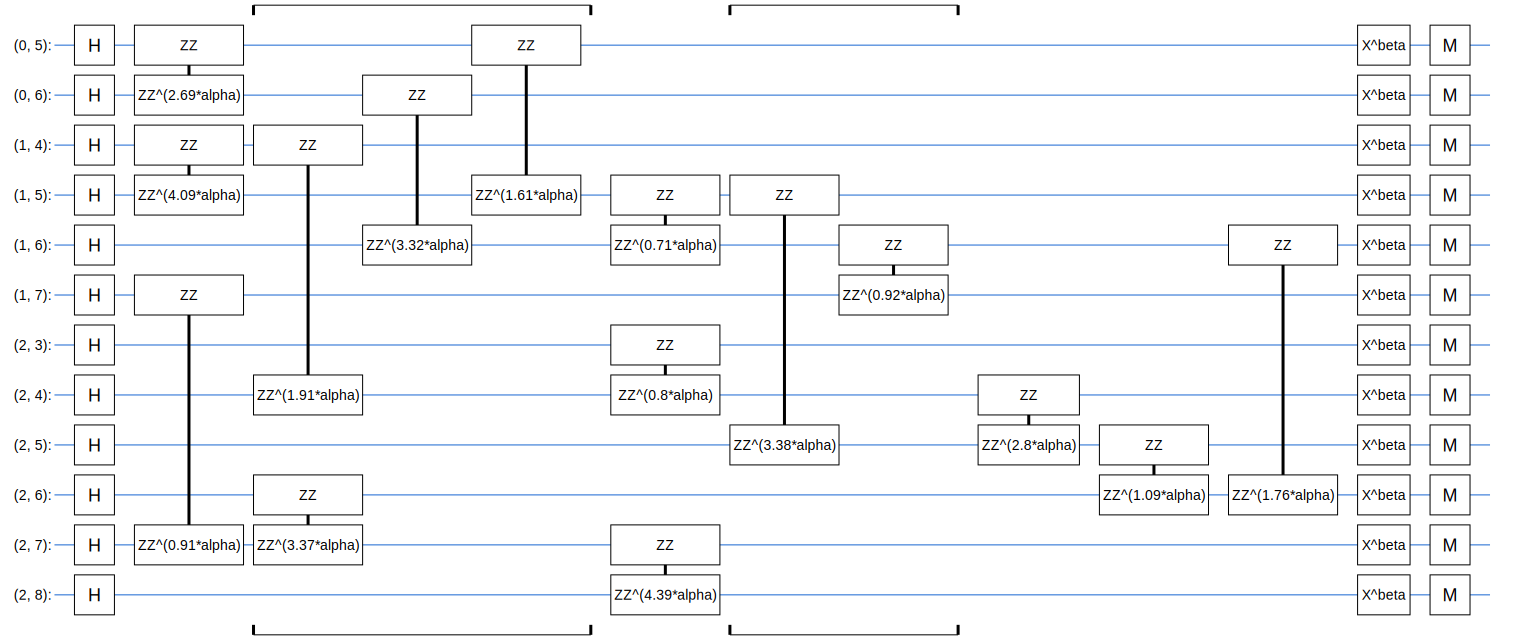

In [7]:
from cirq.contrib.svg import SVGCircuit

# Symbols for the rotation angles in the QAOA circuit.
alpha = sympy.Symbol("alpha")
beta = sympy.Symbol("beta")

qaoa_circuit = cirq.Circuit(
    # Prepare uniform superposition on working_qubits == working_graph.nodes
    cirq.H.on_each(working_graph.nodes()),
    # Do ZZ operations between neighbors u, v in the graph. Here, u is a qubit,
    # v is its neighboring qubit, and w is the weight between these qubits.
    (
        cirq.ZZ(u, v) ** (alpha * w["weight"])
        for (u, v, w) in working_graph.edges(data=True)
    ),
    # Apply X operations along all nodes of the graph. Again working_graph's
    # nodes are the working_qubits. Note here we use a moment
    # which will force all of the gates into the same line.
    cirq.Moment(cirq.X(qubit) ** beta for qubit in working_graph.nodes()),
    # All relevant things can be computed in the computational basis.
    (cirq.measure(qubit) for qubit in working_graph.nodes()),
)
SVGCircuit(qaoa_circuit)

In [8]:
import pandas as pd


def estimate_cost(graph: nx.Graph, samples: pd.DataFrame) -> float:
    """Estimate the cost function of the QAOA on the given graph using the
    provided computational basis bitstrings."""
    cost_value = 0.0

    # Loop over edge pairs and compute contribution.
    for u, v, w in graph.edges(data=True):
        u_samples = samples[str(u)]
        v_samples = samples[str(v)]

        # Determine if it was a +1 or -1 eigenvalue.
        u_signs = (-1) ** u_samples
        v_signs = (-1) ** v_samples
        term_signs = u_signs * v_signs

        # Add scaled term to total cost.
        term_val = np.mean(term_signs) * w["weight"]
        cost_value += term_val

    return -cost_value

In [9]:
alpha_value = np.pi / 4
beta_value = np.pi / 2
sim = cirq.Simulator()

sample_results = sim.sample(
    qaoa_circuit, params={alpha: alpha_value, beta: beta_value}, repetitions=20_000
)
print(f"Alpha = {round(alpha_value, 3)} Beta = {round(beta_value, 3)}")
print(f"Estimated cost: {estimate_cost(working_graph, sample_results)}")

Alpha = 0.785 Beta = 1.571
Estimated cost: -0.8878169999999999


In [10]:
# Set the grid size = number of points in the interval [0, 2π).
grid_size = 5

alpha_sweep = cirq.Linspace(alpha, 0, 2 * np.pi, grid_size)
beta_sweep = cirq.Linspace(beta, 0, 2 * np.pi, grid_size)
samples = sim.run_sweep(
    qaoa_circuit, params=alpha_sweep * beta_sweep, repetitions=20000
)

exp_values = np.reshape(samples, (-1, grid_size)).tolist()
estimate = np.vectorize(lambda s: estimate_cost(working_graph, s.data))
exp_values = estimate(exp_values)
par_tuples = [tuple(y[1] for y in x) for x in (alpha_sweep * beta_sweep).param_tuples()]
par_values = np.reshape(par_tuples, (-1, grid_size, 2))

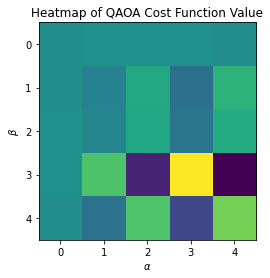

In [11]:
plt.title("Heatmap of QAOA Cost Function Value")
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.imshow(exp_values)
plt.show()

In [12]:
def output_cut(s_partition: List[cirq.Qid]) -> None:
    """Plot and output the graph cut information."""

    # Generate the colors.
    coloring = []
    for node in working_graph:
        if node in s_partition:
            coloring.append("blue")
        else:
            coloring.append("red")

    # Get the weights
    edges = working_graph.edges(data=True)
    weights = [w["weight"] for (u, v, w) in edges]

    nx.draw_circular(
        working_graph,
        node_color=coloring,
        node_size=1000,
        with_labels=True,
        width=weights,
    )
    plt.show()
    size = nx.cut_size(working_graph, s_partition, weight="weight")
    print(f"Cut size: {size}")

In [13]:
# Test with the empty S and all nodes placed in T.
output_cut([])

TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>

In [14]:
best_exp_index = np.unravel_index(np.argmax(exp_values), exp_values.shape)
print(best_exp_index, type(best_exp_index))
best_parameters = par_values[best_exp_index]
print(f"Best control parameters: {best_parameters}")

(3, 3) <class 'tuple'>
Best control parameters: [4.71238898 4.71238898]


In [15]:
# Number of candidate cuts to sample.
num_cuts = 100
candidate_cuts = sim.sample(
    qaoa_circuit,
    params={alpha: best_parameters[0], beta: best_parameters[1]},
    repetitions=num_cuts,
)

# Variables to store best cut partitions and cut size.
best_qaoa_S_partition = set()
best_qaoa_T_partition = set()
best_qaoa_cut_size = -np.inf

# Analyze each candidate cut.
for i in range(num_cuts):
    candidate = candidate_cuts.iloc[i]
    one_qubits = set(candidate[candidate == 1].index)
    S_partition = set()
    T_partition = set()
    for node in working_graph:
        if str(node) in one_qubits:
            # If a one was measured add node to S partition.
            S_partition.add(node)
        else:
            # Otherwise a zero was measured so add to T partition.
            T_partition.add(node)

    cut_size = nx.cut_size(working_graph, S_partition, T_partition, weight="weight")

    # If you found a better cut update best_qaoa_cut variables.
    if cut_size > best_qaoa_cut_size:
        best_qaoa_cut_size = cut_size
        best_qaoa_S_partition = S_partition
        best_qaoa_T_partition = T_partition

In [16]:
import random

best_random_S_partition = set()
best_random_T_partition = set()
best_random_cut_size = -9999

# Randomly build candidate sets.
for i in range(num_cuts):
    S_partition = set()
    T_partition = set()
    for node in working_graph:
        if random.random() > 0.5:
            # If we flip heads add to S.
            S_partition.add(node)
        else:
            # Otherwise add to T.
            T_partition.add(node)

    cut_size = nx.cut_size(working_graph, S_partition, T_partition, weight="weight")

    # If you found a better cut update best_random_cut variables.
    if cut_size > best_random_cut_size:
        best_random_cut_size = cut_size
        best_random_S_partition = S_partition
        best_random_T_partition = T_partition

In [18]:
print("-----QAOA-----")
output_cut(best_qaoa_S_partition)

print("\n\n-----RANDOM-----")
output_cut(best_random_S_partition)

-----QAOA-----


TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>